# 电力负荷数据合成：解锁电网分析新可能

在现代电力系统中，数据是驱动洞察和优化的核心。然而，获取、管理和共享真实电力负荷数据常常面临隐私、成本和数据稀疏性等挑战。**电力负荷数据合成**提供了一个强大的解决方案，它利用先进的机器学习技术来生成与真实数据统计特性相似的**人造数据**。这不仅能有效弥补数据不足，还能在保护隐私的前提下，为电网的分析、预测、优化及算法测试提供丰富、多样化的数据支持。

### 为何合成电力负荷数据如此重要？

* **隐私保护与合规性：** 真实的电力数据往往包含敏感的用户行为信息。合成数据允许在不暴露原始数据的情况下进行分析和共享，满足严格的数据隐私法规要求。
* **弥补数据不足：** 面对传感器故障、通信中断或特定历史数据缺失时，合成数据能够填补空白，构建更完整、连续的数据集。
* **数据增强与多样化：** 通过生成不同条件（如极端天气、突发事件）下的数据，我们可以扩充现有数据集，提高模型的泛化能力和鲁棒性，让算法在更广泛的场景下表现出色。
* **算法测试与开发：** 无论是新的负荷预测模型还是需求响应策略，都需要大量数据进行训练和验证。合成数据提供了一个安全、可控的环境，加速算法的迭代和优化。
* **降低成本：** 相较于真实数据的采集、清洗和存储，合成数据显著降低了数据获取的成本和复杂度。



---

### 核心合成模型与方法

电力负荷数据合成主要依赖于**深度生成模型**，这些模型擅长学习复杂数据的高维分布并生成逼真样本。

#### 1. 条件变分自编码器 (CVAE)

我们此次实现的核心模型就是 **CVAE**。

* **工作原理：** CVAE 能够学习在给定**条件信息**（例如：温度、湿度、风速、日期和时间等环境与时序特征）时，电力负荷数据（`PowerConsumption_Zone1, Zone2, Zone3`）的分布。它将输入数据编码成一个**潜在空间**中的概率分布，再由解码器结合条件信息从该潜在空间中采样并重建数据。
* **优势：** CVAE 能够生成具有多样性的数据，并且最关键的是，它允许我们**控制生成过程**，根据特定的环境和时间条件来定制合成的电力负荷数据，这对于模拟特定场景下的电力行为至关重要。

#### 2. 生成对抗网络 (GANs)

* **工作原理：** GANs 由一个**生成器**和一个**判别器**组成。生成器负责创造看起来真实的合成数据，而判别器则努力区分真实数据和生成数据。两者在对抗中不断提升，最终生成器能够产生高度逼真的数据。
* **优势：** 在生成视觉上极度逼真的数据方面表现卓越，也能应用于时序数据。

#### 3. 扩散模型 (Diffusion Models)

* **工作原理：** 这类模型通过模拟一个逐步添加噪声的“前向扩散”过程，然后学习逆向的“去噪”过程来生成数据。
* **优势：** 近年来在图像和音频生成领域取得了突破性进展，能够生成高质量、细节丰富的样本，在复杂数据分布建模方面潜力巨大，是未来在电力数据合成领域值得探索的方向。



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from pylab import mpl, plt
import matplotlib.patches as mpatches

# best font and style settings for notebook
warnings.filterwarnings('ignore')
sns.set_style("white")
mpl.rcParams['font.family'] = 'MiSans'

# 读取数据
df = pd.read_csv("./data/powerconsumption.csv")

# 时间格式处理
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

# --- 数据预处理 ---

# 提取时间特征
df['Hour'] = df['Datetime'].dt.hour
df['DayOfWeek'] = df['Datetime'].dt.dayofweek
df['Month'] = df['Datetime'].dt.month

# 定义条件特征和目标特征
conditional_features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows', 'Hour',
                        'DayOfWeek', 'Month']
target_features = ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']

# 将分类时间特征进行独热编码
df_encoded = pd.get_dummies(df, columns=['Hour', 'DayOfWeek', 'Month'], drop_first=False)

# 更新条件特征列表以包含独热编码后的列
encoded_hour_cols = [col for col in df_encoded.columns if 'Hour_' in col]
encoded_dayofweek_cols = [col for col in df_encoded.columns if 'DayOfWeek_' in col]
encoded_month_cols = [col for col in df_encoded.columns if 'Month_' in col]

conditional_features_processed = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows'] + \
                                 encoded_hour_cols + encoded_dayofweek_cols + encoded_month_cols

# 确保所有特征列都存在
missing_conditional_features = [f for f in conditional_features_processed if f not in df_encoded.columns]
if missing_conditional_features:
    raise ValueError(f"Missing conditional features after encoding: {missing_conditional_features}")

# 划分训练集和测试集 (按时间顺序划分)
# 80% 训练，20% 测试
train_size = int(len(df_encoded) * 0.8)
train_df = df_encoded.iloc[:train_size]
test_df = df_encoded.iloc[train_size:]

# 初始化 Min-Max Scaler
scaler_cond = MinMaxScaler()
scaler_target = MinMaxScaler()

# 对训练数据进行拟合和转换
X_train_scaled = scaler_cond.fit_transform(train_df[conditional_features_processed])
y_train_scaled = scaler_target.fit_transform(train_df[target_features])

# 对测试数据进行转换
X_test_scaled = scaler_cond.transform(test_df[conditional_features_processed])
y_test_scaled = scaler_target.transform(test_df[target_features])

# 转换为 PyTorch Tensor
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# 创建 DataLoader
batch_size = 128
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 打印数据形状以供检查
print(f"训练条件特征形状: {X_train_tensor.shape}")
print(f"训练目标特征形状: {y_train_tensor.shape}")
print(f"测试条件特征形状: {X_test_tensor.shape}")
print(f"测试目标特征形状: {y_test_tensor.shape}")

训练条件特征形状: torch.Size([41932, 48])
训练目标特征形状: torch.Size([41932, 3])
测试条件特征形状: torch.Size([10484, 48])
测试目标特征形状: torch.Size([10484, 3])



## CVAE 模型定义

这部分代码定义了 CVAE（条件变分自编码器）的神经网络架构。CVAE 由一个**编码器 (Encoder)** 和一个**解码器 (Decoder)** 组成，它们协同工作，在给定条件信息的情况下，学习数据的潜在表示并生成新的数据样本。

### 模型结构概览

  * **编码器 (Encoder):** 负责将**真实电力消耗数据 (y)** 和其对应的**环境与时间条件 (c)** 映射到一个**潜在空间 (Latent Space)**。它输出的是这个潜在空间中一个高斯分布的**均值 (mu)** 和**对数方差 (log\_var)**。
  * **重参数化技巧 (Reparameterization Trick):** CVAE 使用这个技巧从编码器输出的分布中采样一个潜在变量 **z**。这样做是为了在训练过程中允许梯度流过采样操作。
  * **解码器 (Decoder):** 接收采样的**潜在变量 (z)** 和相同的**环境与时间条件 (c)**，然后尝试重构出原始的**电力消耗数据 (y')**。



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from pylab import mpl  # pylab is part of matplotlib, no need to import plt twice
import matplotlib.patches as mpatches

# Make sure these are defined from your previous preprocessing
# conditional_features_processed_full is expected to be defined somewhere before this.
# Example if not defined:
# encoded_hour_cols = [f'Hour_{i}' for i in range(24)]
# encoded_dayofweek_cols = [f'DayOfWeek_{i}' for i in range(7)]
# encoded_month_cols = [f'Month_{i}' for i in range(1, 13)]
# conditional_features_processed_full = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows'] + \
#                                       encoded_hour_cols + encoded_dayofweek_cols + encoded_month_cols

# Assuming target_features and conditional_features_processed_full are defined from prior cells
# target_features = ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']
# input_dim = len(target_features) # = 3
# conditional_dim = len(conditional_features_processed_full) # = 48 (example)

# Define input_dim and conditional_dim based on your data:
input_dim = len(target_features)
conditional_dim = len(conditional_features_processed)  # Using conditional_features_processed from your provided snippet

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# --- CVAE Part (as a baseline or for latent space) ---
# We'll keep the CVAE definition for now, even if we focus on direct diffusion.
# It can serve as a separate component or inspire feature processing.
class CVAE(nn.Module):
    def __init__(self, input_dim, conditional_dim, latent_dim, dropout_rate=0.2):
        super(CVAE, self).__init__()
        self.input_dim = input_dim
        self.conditional_dim = conditional_dim
        self.latent_dim = latent_dim
        self.dropout_rate = dropout_rate

        self.encoder = nn.Sequential(
            nn.Linear(input_dim + conditional_dim, 512),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate)
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_log_var = nn.Linear(256, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + conditional_dim, 256),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(512, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x, c):
        inputs = torch.cat([x, c], dim=1)
        h = self.encoder(inputs)
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        inputs = torch.cat([z, c], dim=1)
        return self.decoder(inputs)

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z, c)
        return reconstruction, mu, log_var


# --- Diffusion Model Components ---

# 1. U-Net like Noise Prediction Network for Time Series
class NoisePredictionNet(nn.Module):
    def __init__(self, data_dim, cond_dim, time_emb_dim=128):
        """
        用于预测噪声的网络。这里使用简单的MLP结构，但可以扩展为更复杂的U-Net或Transformer。
        输入：加噪数据 (x_t), 条件 (cond), 时间步 (t 的嵌入)
        输出：预测的噪声
        """
        super().__init__()
        self.data_dim = data_dim
        self.cond_dim = cond_dim
        self.time_emb_dim = time_emb_dim

        # 时间步嵌入层
        self.time_mlp = nn.Sequential(
            nn.Linear(1, time_emb_dim),  # Time is a scalar, so 1 input
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )

        # 核心噪声预测网络（MLP for simplicity, can be U-Net)
        self.net = nn.Sequential(
            nn.Linear(data_dim + cond_dim + time_emb_dim, 512),  # Combine data, cond, and time
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, data_dim)  # Output predicted noise, same dim as data
        )

    def forward(self, x_t, cond, t):
        # t is a scalar per sample, expand its dimensions for embedding
        time_emb = self.time_mlp(t.unsqueeze(1).float() / 1000.0)  # Normalize t to [0,1] for better embedding

        # Concatenate x_t, condition, and time embedding
        inputs = torch.cat([x_t, cond, time_emb], dim=1)

        return self.net(inputs)


# 2. Diffusion Model Class
class DiffusionModel(nn.Module):
    def __init__(self, noise_predictor_net, timesteps=1000):
        super().__init__()
        self.noise_predictor_net = noise_predictor_net
        self.timesteps = timesteps

        # 预计算 alpha、beta 和相关项
        # 我们使用固定的线性 Beta 调度
        self.betas = self.linear_beta_schedule(timesteps)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)  # alpha_bar_t
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)  # 1/sqrt(alpha_t)

        # 采样时用于预测 x_0 的系数
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)

        # 用于采样时预测均值的系数 (ddpm)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)

    def linear_beta_schedule(self, timesteps):
        scale = 1000 / timesteps
        beta_start = scale * 0.0001
        beta_end = scale * 0.02
        return torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32)

    def get_index_from_list(self, vals, t, x_shape):
        """
        从预计算列表中获取对应时间步 t 的值
        """
        batch_size = t.shape[0]
        out = vals.gather(-1, t.cpu())
        # Reshape to match x_shape for broadcasting
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

    def forward_diffusion(self, x_0, t, noise=None):
        """
        前向扩散过程：从 x_0 获得 x_t
        x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * noise
        """
        if noise is None:
            noise = torch.randn_like(x_0)

        sqrt_alphas_cumprod_t = self.get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape)

        # 均值 + 噪声
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        return x_t, noise  # 返回 x_t 和用于生成 x_t 的真实噪声

    def backward_diffusion_step(self, x_t, t, cond):
        """
        一步反向扩散（去噪）过程。
        预测噪声，然后从 x_t 估计 x_{t-1}。
        """
        # 预测噪声
        predicted_noise = self.noise_predictor_net(x_t, cond, t)

        sqrt_recip_alphas_t = self.get_index_from_list(self.sqrt_recip_alphas, t, x_t.shape)
        # --- 修复开始 ---
        # 这一行之前缺失了，导致 'sqrt_alphas_cumprod_t' 未被定义
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.sqrt_alphas_cumprod, t, x_t.shape)
        # --- 修复结束 ---
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(self.sqrt_one_minus_alphas_cumprod, t, x_t.shape)
        betas_t = self.get_index_from_list(self.betas, t, x_t.shape)

        # 估计 x_0
        # x_0_hat = (x_t - sqrt(1 - alpha_bar_t) * predicted_noise) / sqrt(alpha_bar_t)
        x_0_hat = (x_t - sqrt_one_minus_alphas_cumprod_t * predicted_noise) / sqrt_alphas_cumprod_t
        x_0_hat = torch.clamp(x_0_hat, -1., 1.)  # Ensure output is in range

        # 估计 x_{t-1} 的均值
        mean = sqrt_recip_alphas_t * (x_t - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t)

        # 添加噪声 (如果 t > 0)
        posterior_variance_t = self.get_index_from_list(self.posterior_variance, t, x_t.shape)
        noise = torch.randn_like(x_t) if t[0] > 0 else 0.  # At t=0, no noise

        x_t_minus_1 = mean + torch.sqrt(posterior_variance_t) * noise
        return x_t_minus_1, predicted_noise, x_0_hat

    @torch.no_grad()
    def sample(self, num_samples, cond):
        """
        从随机噪声开始生成样本。
        """
        # 从随机噪声 x_T 开始
        x = torch.randn(num_samples, self.noise_predictor_net.data_dim, device=cond.device)

        # 逐步去噪
        for i in tqdm(reversed(range(self.timesteps)), desc='Sampling'):
            t = torch.full((num_samples,), i, device=cond.device, dtype=torch.long)
            # Perform one reverse step (get x_{t-1} and predicted noise)
            x, predicted_noise, _ = self.backward_diffusion_step(x, t, cond)  # We only need x for the next step

        return x  # 返回去噪后的样本

    def p_losses(self, x_0, cond, t, noise=None):
        """
        计算训练损失 (预测噪声与真实噪声之间的MSE)。
        """
        x_t, noise = self.forward_diffusion(x_0, t, noise)
        predicted_noise = self.noise_predictor_net(x_t, cond, t)

        # 计算预测噪声和真实噪声之间的 MSE 损失
        loss = F.mse_loss(predicted_noise, noise)
        return loss

Using device: cuda


In [7]:
# # --- 模型初始化 ---
# data_dim = input_dim  # 目标特征维度 (电力消耗 Zone1,2,3)
# cond_dim = conditional_dim  # 条件特征维度 (环境 + 独热编码时间)
# timesteps = 1000  # 扩散步数，可以调整
# 
# noise_predictor_net = NoisePredictionNet(data_dim, cond_dim).to(device)
# diffusion_model = DiffusionModel(noise_predictor_net, timesteps=timesteps).to(device)
# 
# # 定义优化器
# diffusion_optimizer = optim.Adam(diffusion_model.parameters(), lr=1e-4)  # 扩散模型通常使用较小的学习率
# 
# # --- 训练循环 ---
# num_epochs_diffusion = 100  # 可以尝试更多 Epoch
# 
# print("\n--- 开始训练扩散模型 ---")
# for epoch in range(num_epochs_diffusion):
#     diffusion_model.train()  # 切换到训练模式
#     total_loss = 0
#     for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
#         X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move to device
# 
#         # 随机选择一个时间步 t
#         t = torch.randint(0, timesteps, (y_batch.shape[0],), device=device).long()
# 
#         # 计算扩散损失
#         loss = diffusion_model.p_losses(y_batch, X_batch, t)
# 
#         diffusion_optimizer.zero_grad()
#         loss.backward()
#         diffusion_optimizer.step()
# 
#         total_loss += loss.item()
# 
#     avg_loss = total_loss / len(train_loader)
#     print(f"Epoch {epoch + 1}/{num_epochs_diffusion}, Loss: {avg_loss:.6f}")
# 
#     # (可选) 每隔 N 个 Epoch 在测试集上进行评估或生成样本
#     if (epoch + 1) % 10 == 0:
#         diffusion_model.eval()  # 切换到评估模式
#         with torch.no_grad():
#             # 简单评估：生成一批样本并检查其统计特性
#             # 随机选择一个测试批次的条件来生成
#             test_cond_batch, _ = next(iter(test_loader))
#             test_cond_batch = test_cond_batch.to(device)
# 
#             generated_samples = diffusion_model.sample(batch_size, test_cond_batch).cpu().numpy()
# 
#             # 由于生成的是在 [0,1] 范围的归一化数据，需要反归一化才能与原始数据比较
#             generated_samples_unscaled = scaler_target.inverse_transform(generated_samples)
# 
#             print(f"  --- Epoch {epoch + 1} 评估 ---")
#             for i, zone in enumerate(target_features):
#                 print(f"    生成样本 {zone} 均值: {generated_samples_unscaled[:, i].mean():.2f}")
#                 print(f"    生成样本 {zone} 标准差: {generated_samples_unscaled[:, i].std():.2f}")
#             # 注意：这里的评估只是初步的，更严谨的评估需要与真实测试数据进行分布比较
# 
# print("\n--- 扩散模型训练完成 ---")

使用设备: cuda

--- 开始训练扩散模型 ---


Training Diffusion Model:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.041373
Epoch 5/20, Test Loss: 0.077913 (Evaluation)
Epoch 10/20, Train Loss: 0.028690
Epoch 10/20, Test Loss: 0.077796 (Evaluation)
Epoch 15/20, Train Loss: 0.025613
Epoch 15/20, Test Loss: 0.095707 (Evaluation)
Epoch 20/20, Train Loss: 0.024465
Epoch 20/20, Test Loss: 0.103379 (Evaluation)

--- 扩散模型训练完成 ---


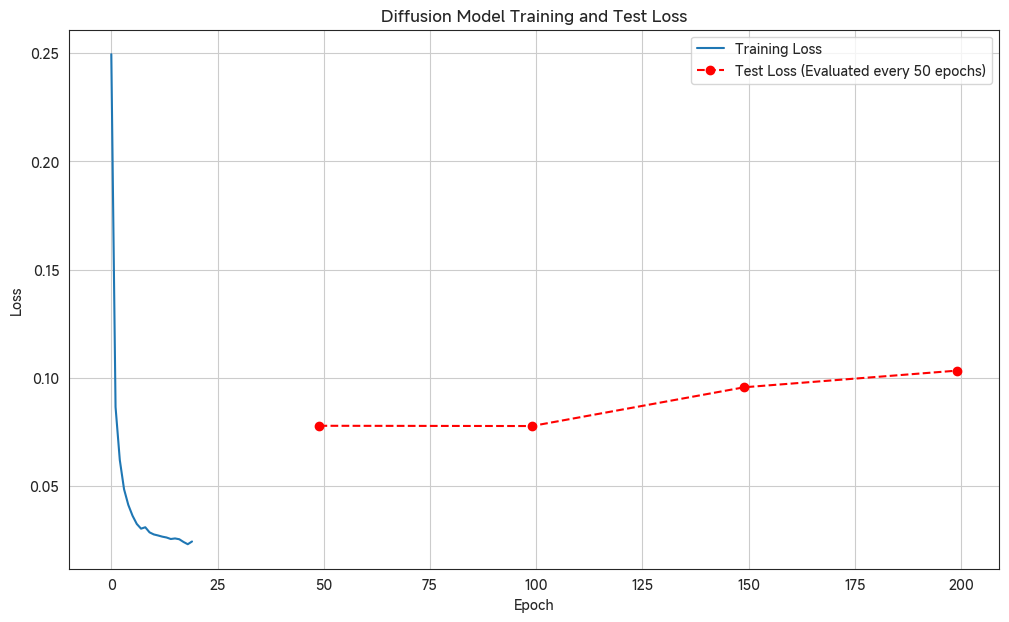

In [8]:

# --- Model Initialization ---
data_dim = input_dim
cond_dim = conditional_dim
timesteps = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

noise_predictor_net = NoisePredictionNet(data_dim, cond_dim).to(device)
diffusion_model = DiffusionModel(noise_predictor_net, timesteps=timesteps).to(device)

diffusion_optimizer = optim.Adam(diffusion_model.parameters(), lr=1e-4)

# --- 训练循环 (每50轮在测试集上评估) ---
num_epochs_diffusion = 20  # Consider increasing this for better results

train_losses_diffusion = []
test_losses_diffusion = []  # Store test losses for diffusion model

print("\n--- 开始训练扩散模型 ---")
for epoch in tqdm(range(num_epochs_diffusion), desc="Training Diffusion Model"):
    # --- 训练阶段 ---
    diffusion_model.train()  # Set model to training mode
    total_train_loss = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        t = torch.randint(0, timesteps, (y_batch.shape[0],), device=device).long()

        loss = diffusion_model.p_losses(y_batch, X_batch, t)

        diffusion_optimizer.zero_grad()
        loss.backward()
        diffusion_optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)  # Average loss per batch
    train_losses_diffusion.append(avg_train_loss)

    # Print training loss every 10 epochs (or adjust as needed)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch + 1}/{num_epochs_diffusion}, Train Loss: {avg_train_loss:.6f}")

        # --- 测试集评估阶段 ---

        diffusion_model.eval()  # Set model to evaluation mode
        total_test_loss = 0
        with torch.no_grad():  # Disable gradient calculations
            for X_batch_test, y_batch_test in test_loader:
                X_batch_test, y_batch_test = X_batch_test.to(device), y_batch_test.to(device)

                # For diffusion models, test loss is still the noise prediction loss
                # It's not a 'reconstruction' loss in the same way as CVAE.
                # Here, we randomly sample `t` for consistency, but you could also iterate through `t`
                # for a more comprehensive evaluation if needed.
                t_test = torch.randint(0, timesteps, (y_batch_test.shape[0],), device=device).long()
                test_loss = diffusion_model.p_losses(y_batch_test, X_batch_test, t_test)
                total_test_loss += test_loss.item()

        avg_test_loss = total_test_loss / len(test_loader)  # Average loss per batch for test set
        test_losses_diffusion.append(avg_test_loss)
        print(f"Epoch {epoch + 1}/{num_epochs_diffusion}, Test Loss: {avg_test_loss:.6f} (Evaluation)")

        # Optional: Print generated sample statistics on test set during evaluation
        # This gives a more intuitive sense of generation quality
        # test_cond_batch, _ = next(iter(test_loader))
        # test_cond_batch = test_cond_batch.to(device)
        # generated_samples = diffusion_model.sample(batch_size, test_cond_batch).cpu().numpy()
        # generated_samples_unscaled = scaler_target.inverse_transform(generated_samples)
        # print(f"  --- Epoch {epoch+1} Sample Statistics ---")
        # for i, zone in enumerate(target_features):
        #     print(f"    生成样本 {zone} 均值: {generated_samples_unscaled[:, i].mean():.2f}")
        #     print(f"    生成样本 {zone} 标准差: {generated_samples_unscaled[:, i].std():.2f}")

print("\n--- 扩散模型训练完成 ---")

# 绘制训练损失和测试损失曲线
plt.figure(figsize=(12, 7))
plt.plot(train_losses_diffusion, label='Training Loss')
# For test_losses_diffusion, we need to adjust the x-axis to align with the epochs they were recorded
test_epochs_diffusion = [(i + 1) * 50 - 1 for i in range(
    len(test_losses_diffusion))]  # -1 because list is 0-indexed and plots are 0-indexed from epoch 0
plt.plot(test_epochs_diffusion, test_losses_diffusion, label='Test Loss (Evaluated every 50 epochs)', marker='o',
         linestyle='--', color='red')
plt.title('Diffusion Model Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


--- 开始生成电力消耗样本 (使用测试条件) ---


Sampling: 0it [00:00, ?it/s]


--- 生成完成，开始评估 ---


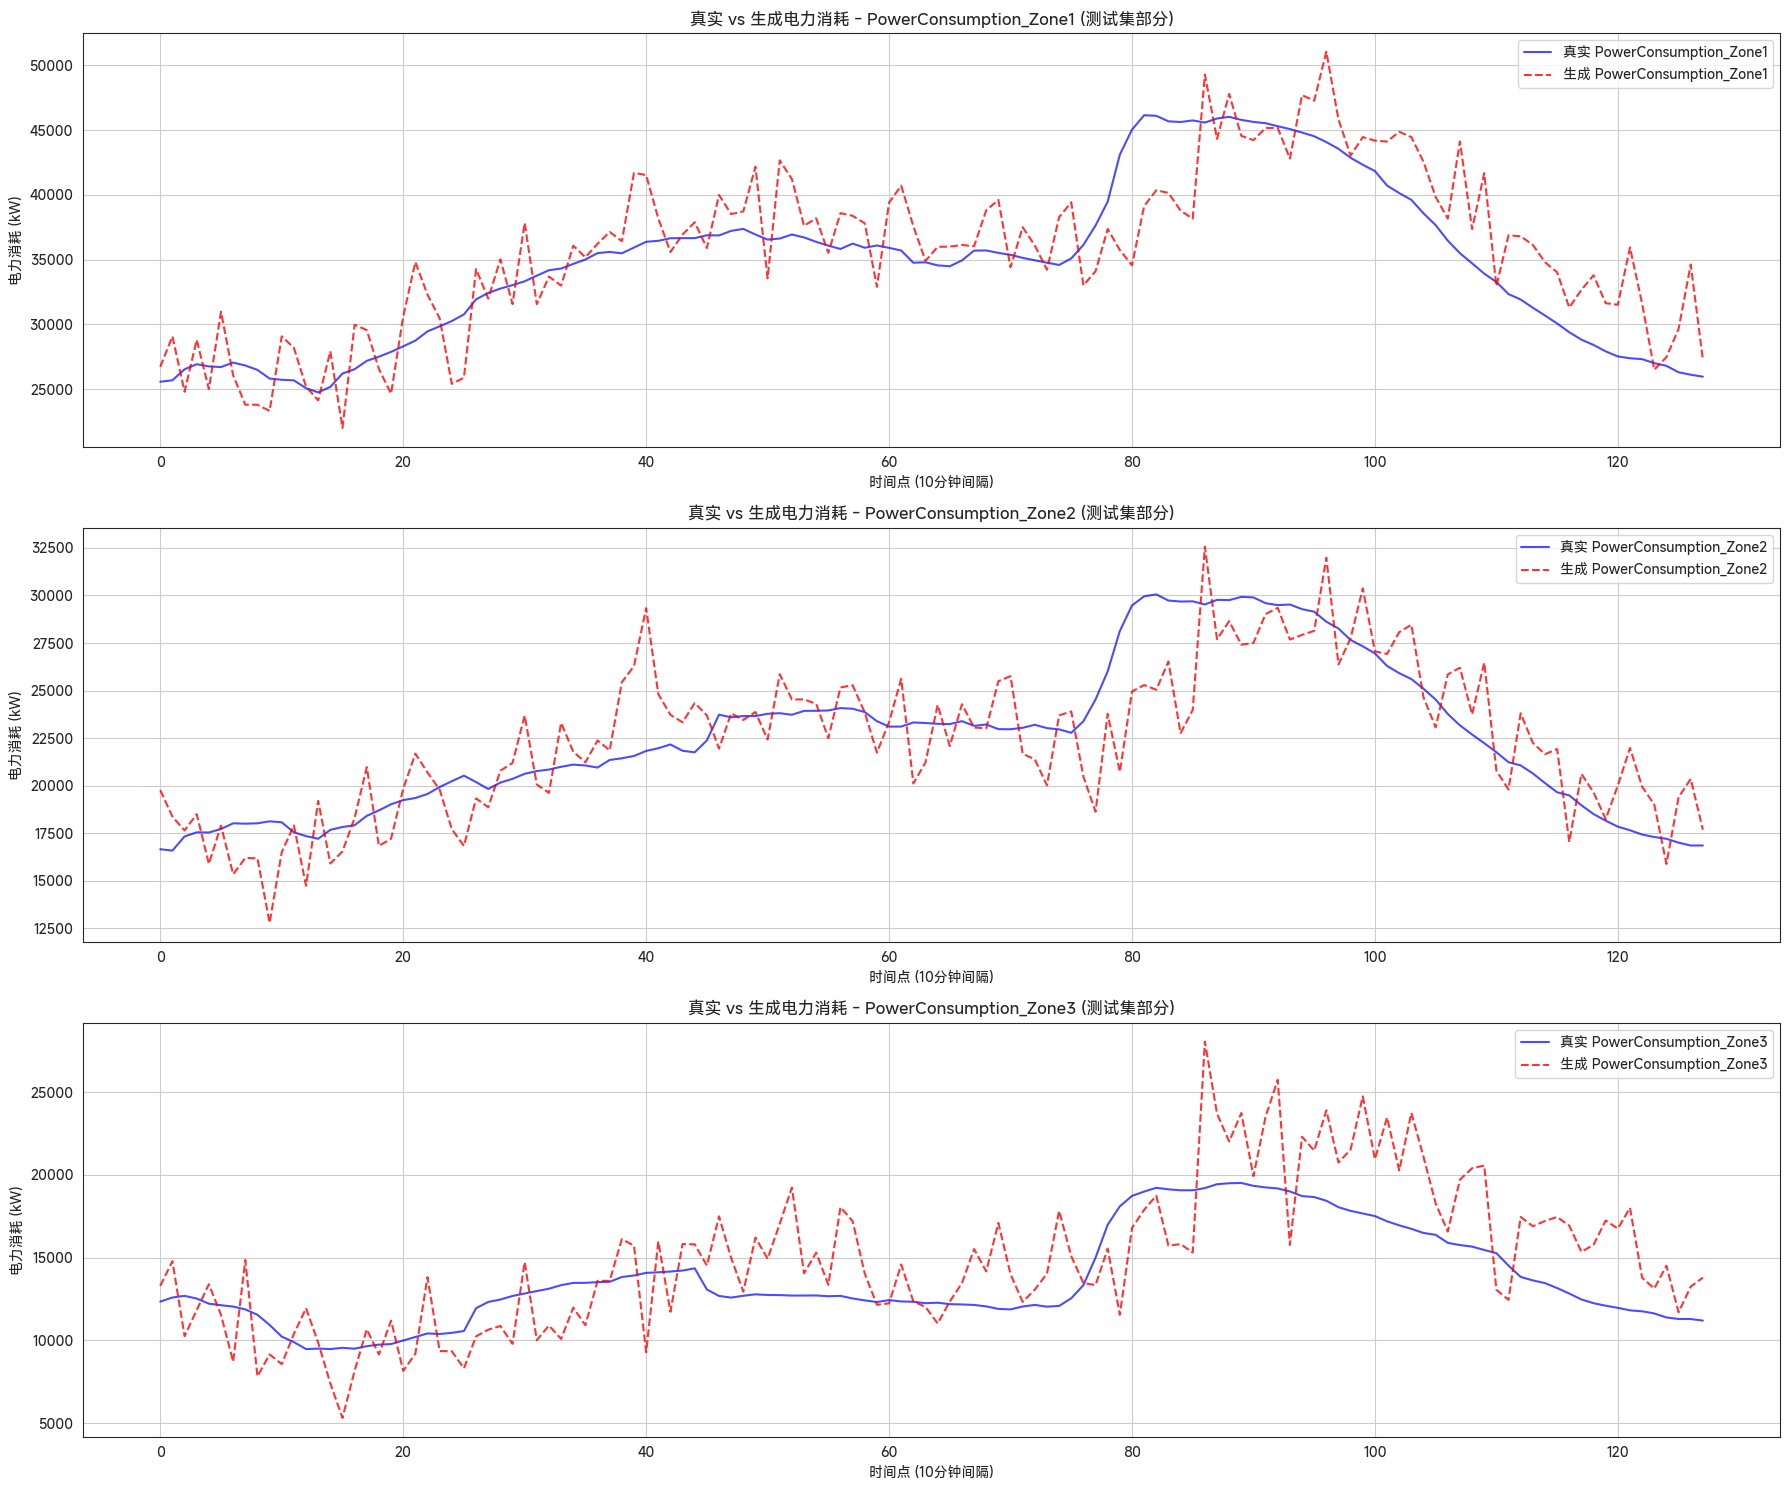


--- 真实数据 vs. 扩散模型生成数据统计比较 (测试集) ---

PowerConsumption_Zone1:
  真实数据均值: 34614.75
  生成数据均值: 35775.73
  真实数据标准差: 6156.72
  生成数据标准差: 6249.24


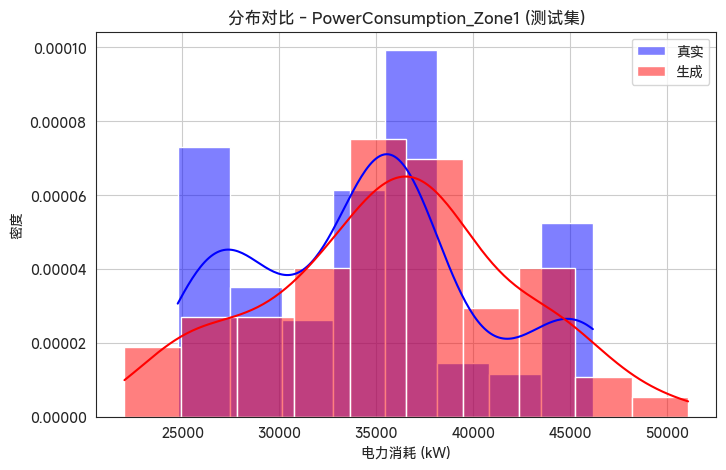


PowerConsumption_Zone2:
  真实数据均值: 22446.20
  生成数据均值: 22436.14
  真实数据标准差: 3885.04
  生成数据标准差: 3879.92


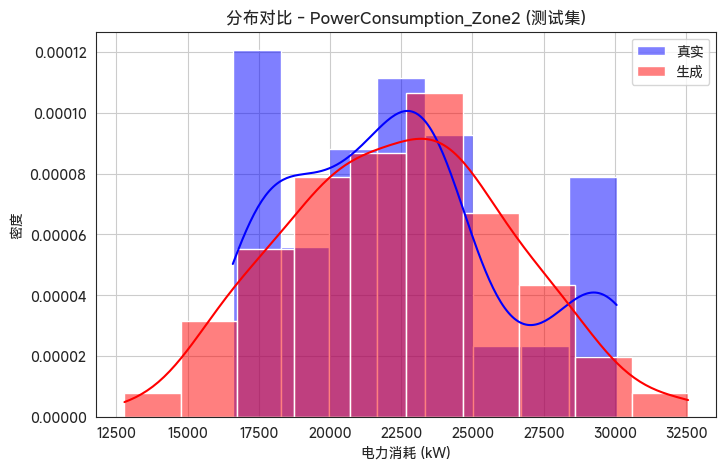


PowerConsumption_Zone3:
  真实数据均值: 13676.81
  生成数据均值: 14910.53
  真实数据标准差: 2832.77
  生成数据标准差: 4406.00


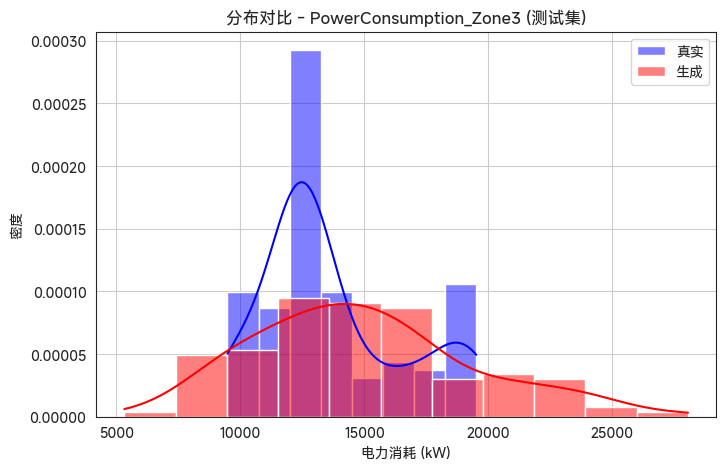


--- 各区域生成样本与真实值的均方误差 (MSE) ---
  请注意：此 MSE 反映的是单次随机生成样本与真实值之间的差异，并非传统预测模型的确定性误差。
  PowerConsumption_Zone1_MSE: 13231216.0000
  PowerConsumption_Zone2_MSE: 6084826.0000
  PowerConsumption_Zone3_MSE: 10182174.0000


In [9]:
# --- 使用训练好的扩散模型进行生成 ---
from sklearn.metrics import mean_squared_error  # 导入 MSE 计算函数

diffusion_model.eval()  # 切换到评估模式

# 1. 选择一个测试批次的条件来生成
# 或者，如果您想生成特定条件的样本，可以构建一个 X_input_tensor
test_cond_batch_for_gen, real_y_batch_for_gen = next(iter(test_loader))
test_cond_batch_for_gen = test_cond_batch_for_gen.to(device)
real_y_batch_for_gen_unscaled = scaler_target.inverse_transform(real_y_batch_for_gen.cpu().numpy())

# 生成样本
print("\n--- 开始生成电力消耗样本 (使用测试条件) ---")
generated_samples_final = diffusion_model.sample(test_cond_batch_for_gen.shape[0],
                                                 test_cond_batch_for_gen).cpu().numpy()

# 反归一化生成的样本
generated_samples_final_unscaled = scaler_target.inverse_transform(generated_samples_final)

print("\n--- 生成完成，开始评估 ---")

# --- 可视化对比：时序图 (生成 vs 真实) ---
# 选择绘制的样本数量，例如第一个批次的全部或部分
num_points_to_plot_gen = min(generated_samples_final_unscaled.shape[0], 24 * 6 * 2)  # 绘制两天的数据
num_points_to_plot_gen = 1008
plt.figure(figsize=(18, 15))

for i, zone in enumerate(target_features):
    plt.subplot(len(target_features), 1, i + 1)
    # 绘制真实数据
    plt.plot(real_y_batch_for_gen_unscaled[:num_points_to_plot_gen, i], label=f'真实 {zone}', color='blue', alpha=0.7)
    # 绘制生成数据
    plt.plot(generated_samples_final_unscaled[:num_points_to_plot_gen, i], label=f'生成 {zone}', color='red',
             linestyle='--', alpha=0.8)
    plt.title(f'真实 vs 生成电力消耗 - {zone} (测试集部分)')
    plt.xlabel('时间点 (10分钟间隔)')
    plt.ylabel('电力消耗 (kW)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# --- 统计指标与分布对比 (真实 vs 生成) ---
print("\n--- 真实数据 vs. 扩散模型生成数据统计比较 (测试集) ---")
for i, zone in enumerate(target_features):
    print(f"\n{zone}:")
    print(f"  真实数据均值: {real_y_batch_for_gen_unscaled[:, i].mean():.2f}")
    print(f"  生成数据均值: {generated_samples_final_unscaled[:, i].mean():.2f}")
    print(f"  真实数据标准差: {real_y_batch_for_gen_unscaled[:, i].std():.2f}")
    print(f"  生成数据标准差: {generated_samples_final_unscaled[:, i].std():.2f}")

    plt.figure(figsize=(8, 5))
    sns.histplot(real_y_batch_for_gen_unscaled[:, i], color='blue', label='真实', kde=True, stat='density', alpha=0.5)
    sns.histplot(generated_samples_final_unscaled[:, i], color='red', label='生成', kde=True, stat='density', alpha=0.5)
    plt.title(f'分布对比 - {zone} (测试集)')
    plt.xlabel('电力消耗 (kW)')
    plt.ylabel('密度')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 计算生成样本与真实样本的 MSE (注意其局限性) ---
print("\n--- 各区域生成样本与真实值的均方误差 (MSE) ---")
print("  请注意：此 MSE 反映的是单次随机生成样本与真实值之间的差异，并非传统预测模型的确定性误差。")
for i, zone in enumerate(target_features):
    mse = mean_squared_error(real_y_batch_for_gen_unscaled[:, i], generated_samples_final_unscaled[:, i])
    print(f"  {zone}_MSE: {mse:.4f}")

In [10]:
len(generated_samples_final_unscaled)

128

In [11]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from pylab import mpl  # pylab is part of matplotlib, no need to import plt twice

# Ensure device, diffusion_model, scaler_target, target_features, X_test_tensor, y_test_tensor are defined from previous cells.

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 生成整个测试集的数据 ---
diffusion_model.eval()  # Set model to evaluation mode

# We need to iterate through the test_loader to get all X_test_tensor in batches
# and generate corresponding y.
all_generated_y_unscaled = []
all_real_y_unscaled = []

print("\n--- Diffusion Model: Generating samples for the entire test set ---")

with torch.no_grad():  # Disable gradient calculations for inference
    for X_batch, y_real_batch in tqdm(test_loader, desc="Generating full test set data"):
        X_batch = X_batch.to(device)  # Move conditions to the device

        # Generate samples for the current batch
        # The .sample() method handles the reverse diffusion process
        generated_y_batch_scaled = diffusion_model.sample(X_batch.shape[0], X_batch).cpu().numpy()

        # Inverse transform both real and generated data
        real_y_batch_unscaled = scaler_target.inverse_transform(y_real_batch.cpu().numpy())
        generated_y_batch_unscaled = scaler_target.inverse_transform(generated_y_batch_scaled)

        all_generated_y_unscaled.append(generated_y_batch_unscaled)
        all_real_y_unscaled.append(real_y_batch_unscaled)

# Concatenate all generated and real batches to get the full arrays
generated_y_unscaled_full = np.vstack(all_generated_y_unscaled)
real_y_test_unscaled_full = np.vstack(all_real_y_unscaled)

print(f"Generated data shape (full test set): {generated_y_unscaled_full.shape}")
print(f"Real data shape (full test set): {real_y_test_unscaled_full.shape}")


--- Diffusion Model: Generating samples for the entire test set ---


Generating full test set data:   0%|          | 0/82 [00:00<?, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Sampling: 0it [00:00, ?it/s]

Generated data shape (full test set): (10484, 3)
Real data shape (full test set): (10484, 3)



--- 真实数据 vs. 扩散模型生成电力消耗 (整个测试集) ---


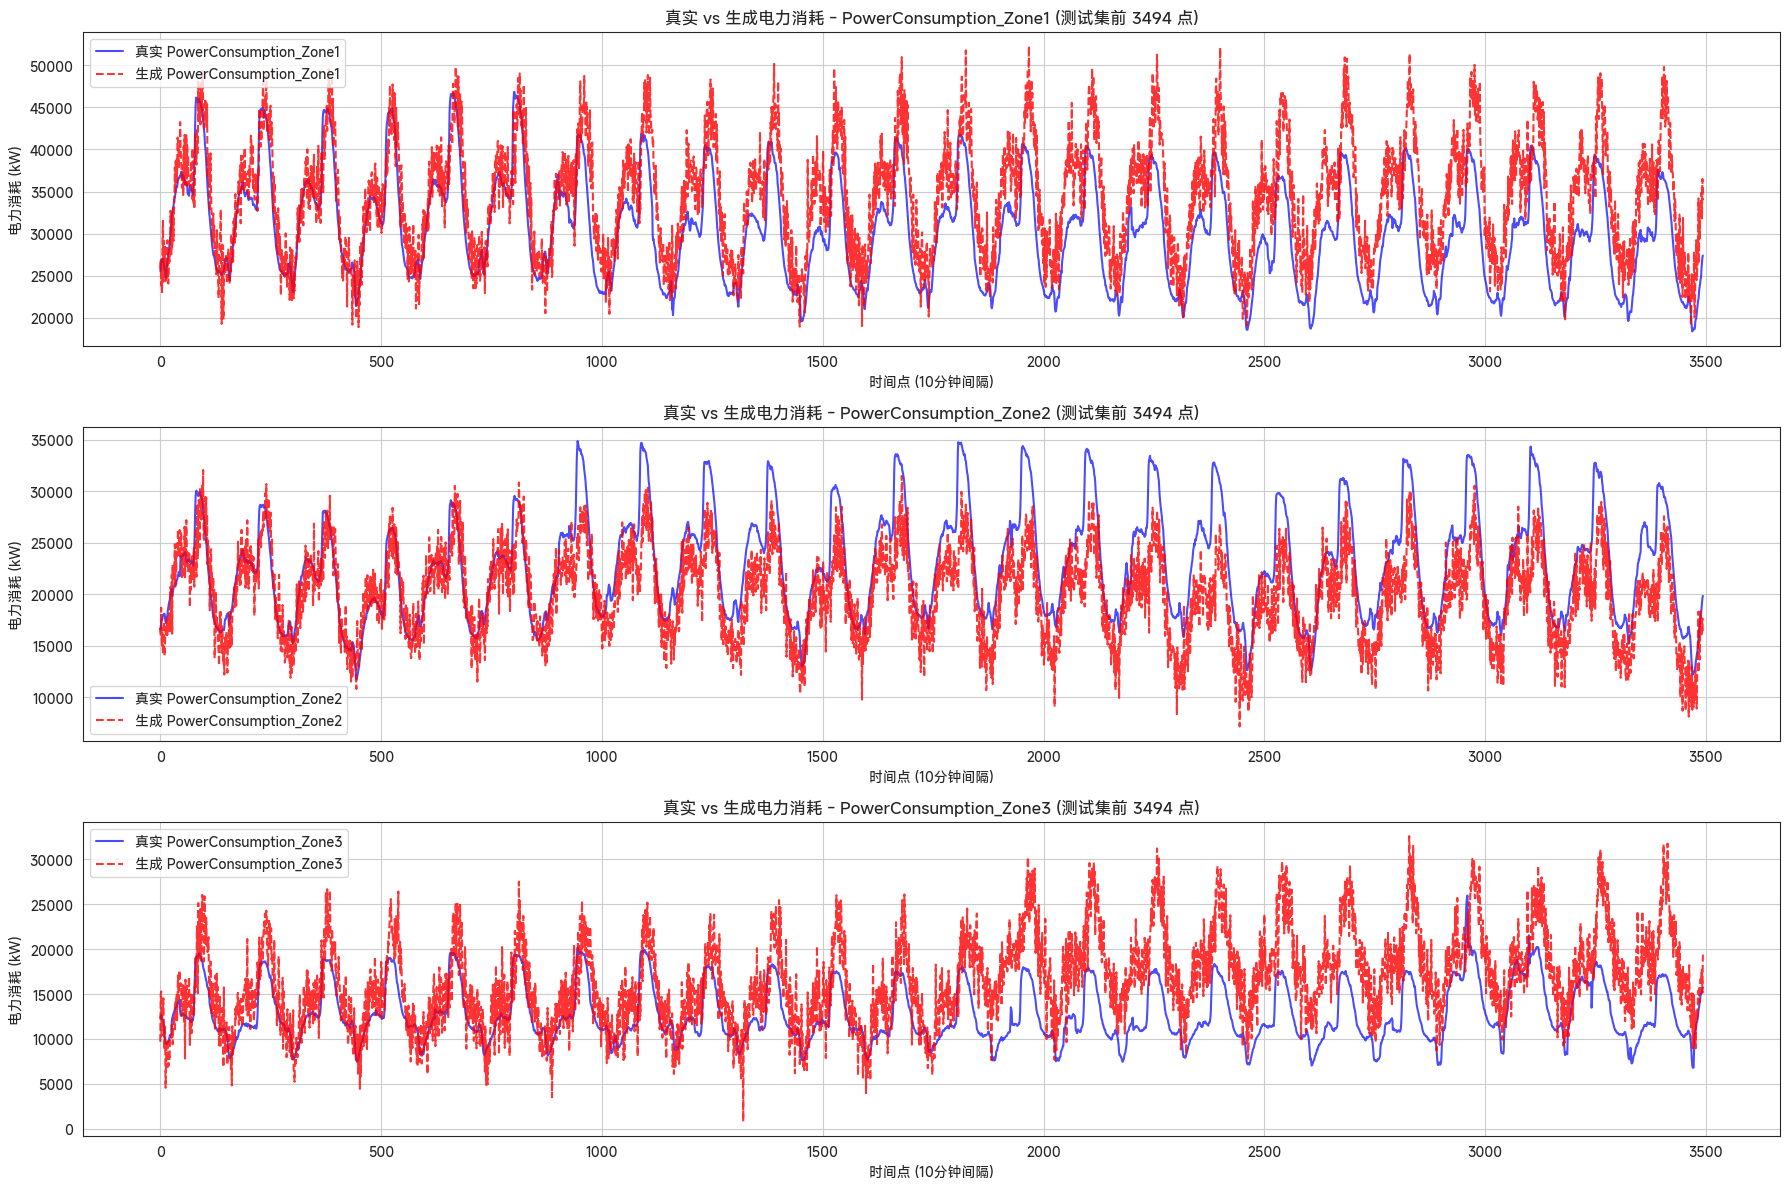

In [12]:
# --- 可视化对比：生成时序图 (扩散模型) ---
print("\n--- 真实数据 vs. 扩散模型生成电力消耗 (整个测试集) ---")

# Determine the number of points to plot. You can adjust this for clarity.
# For example, to plot the first week (7 days * 24 hours/day * 6 intervals/hour)
num_points_to_plot_diffusion_vis = min(len(real_y_test_unscaled_full),
                                       24 * 6 * 7)  # Plot up to one week of data, or less if test set is smaller
num_points_to_plot_diffusion_vis = len(real_y_test_unscaled_full)
num_points_to_plot_diffusion_vis = len(real_y_test_unscaled_full) // 3
plt.figure(figsize=(18, 12))

for i, zone in enumerate(target_features):
    plt.subplot(len(target_features), 1, i + 1)
    plt.plot(real_y_test_unscaled_full[:num_points_to_plot_diffusion_vis, i], label=f'真实 {zone}', color='blue',
             alpha=0.7)
    plt.plot(generated_y_unscaled_full[:num_points_to_plot_diffusion_vis, i], label=f'生成 {zone}', color='red',
             linestyle='--', alpha=0.8)
    plt.title(f'真实 vs 生成电力消耗 - {zone} (测试集前 {num_points_to_plot_diffusion_vis} 点)')
    plt.xlabel('时间点 (10分钟间隔)')
    plt.ylabel('电力消耗 (kW)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
import pandas as pd
import torch
import numpy as np


# 确保以下变量在您的环境中是可用的，它们来自您之前的数据预处理和模型训练：
# scaler_cond: 用于条件特征的 MinMaxScaler
# scaler_target: 用于目标特征的 MinMaxScaler
# diffusion_model: 训练好的 DiffusionModel 实例
# device: 'cuda' 或 'cpu'
# conditional_features_processed: 包含所有独热编码后条件特征的完整列表
# target_features: ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']
# df_encoded: 包含所有独热编码列的原始 DataFrame (用于获取所有独热编码的列名)

def generate_power_consumption(input_series_or_df_row):
    """
    根据给定的条件特征，使用训练好的扩散模型生成电力消耗值。

    参数:
        input_series_or_df_row (pd.Series 或 pd.DataFrame 行):
            包含以下原始条件特征的单行数据：
            'Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows',
            'Hour', 'DayOfWeek', 'Month'。
            示例: df.iloc[0,:6] 这样的格式。

    返回:
        pd.Series: 包含生成的电力消耗值 PowerConsumption_Zone1, PowerConsumption_Zone2, PowerConsumption_Zone3。
                   由于扩散模型的随机性，每次运行结果可能不同。
    """
    diffusion_model.eval()  # 确保模型处于评估模式

    # 1. 数据预处理：转换为 DataFrame 并进行独热编码
    # 如果输入是 Series，将其转换为单行 DataFrame
    if isinstance(input_series_or_df_row, pd.Series):
        input_df = input_series_or_df_row.to_frame().T
    else:  # 如果已经是 DataFrame 行
        input_df = input_series_or_df_row.copy()

    # 确保原始分类时间特征存在
    original_time_features = ['Hour', 'DayOfWeek', 'Month']
    for feature in original_time_features:
        if feature not in input_df.columns:
            raise ValueError(f"输入中缺少原始时间特征 '{feature}'。请确保输入包含 'Hour', 'DayOfWeek', 'Month'。")

    # 创建一个与 df_encoded 具有相同列的空 DataFrame，用于独热编码
    # 这一步很关键，因为 pd.get_dummies 可能会根据输入内容生成不同数量的列
    # 我们需要确保它生成所有可能的独热编码列，即使当前输入中没有某些类别
    template_df = pd.DataFrame(0, index=[0], columns=conditional_features_processed)

    # 将原始环境特征复制过来
    env_features = ['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows', 'DiffuseFlows']
    for feature in env_features:
        if feature in input_df.columns:
            template_df.loc[0, feature] = input_df.loc[input_df.index[0], feature]
        else:
            raise ValueError(f"输入中缺少环境特征 '{feature}'。")

    # 对时间特征进行独热编码
    # 从原始的 'Hour', 'DayOfWeek', 'Month' 生成独热编码列
    hour_val = input_df.loc[input_df.index[0], 'Hour']
    dayofweek_val = input_df.loc[input_df.index[0], 'DayOfWeek']
    month_val = input_df.loc[input_df.index[0], 'Month']

    # 确保独热编码的列名与训练时一致
    if f'Hour_{int(hour_val)}' in template_df.columns:
        template_df.loc[0, f'Hour_{int(hour_val)}'] = 1
    if f'DayOfWeek_{int(dayofweek_val)}' in template_df.columns:
        template_df.loc[0, f'DayOfWeek_{int(dayofweek_val)}'] = 1
    if f'Month_{int(month_val)}' in template_df.columns:
        template_df.loc[0, f'Month_{int(month_val)}'] = 1

    # 2. 对处理后的条件特征进行 Min-Max 缩放
    # 确保顺序与训练时一致
    scaled_cond_features = scaler_cond.transform(template_df[conditional_features_processed])

    # 3. 转换为 PyTorch 张量并移动到设备
    cond_tensor = torch.tensor(scaled_cond_features, dtype=torch.float32).to(device)

    # 4. 使用扩散模型生成电力消耗值
    with torch.no_grad():
        # 生成一个样本
        generated_power_scaled = diffusion_model.sample(1, cond_tensor).cpu().numpy()

    # 5. 反归一化
    generated_power_unscaled = scaler_target.inverse_transform(generated_power_scaled)

    # 6. 转换为 Pandas Series 返回
    result_series = pd.Series(generated_power_unscaled[0], index=target_features)

    return result_series


# --- 示例使用 ---
print("\n--- 示例：使用 df.iloc[0,:6] 生成电力消耗 ---")

# 假设 df 已经加载并进行了初始的时间特征提取
# df['Hour'] = df['Datetime'].dt.hour
# df['DayOfWeek'] = df['Datetime'].dt.dayofweek
# df['Month'] = df['Datetime'].dt.month

# 挑选 df 的第一行作为输入（包含温度、湿度、风速等，以及Hour, DayOfWeek, Month）
# 注意：确保这一行包含所有原始条件特征，尤其是'Hour', 'DayOfWeek', 'Month'
sample_input_row = df.iloc[1, :].copy()  # 使用 .copy() 避免 SettingWithCopyWarning
# 确保取到的是原始的条件特征，通常 df.iloc[0] 会包含所有列，
# 这里指定前6列可能不够，需要确认 df 的列顺序
# 例如，如果 df 的前6列是Datetime, Temperature, Humidity, WindSpeed, GeneralDiffuseFlows, DiffuseFlows，
# 那么还需要手动添加 Hour, DayOfWeek, Month
if 'Hour' not in sample_input_row.index:  # 检查是否已经包含了 Hour/DayOfWeek/Month
    sample_input_row['Hour'] = df.iloc[0]['Datetime'].hour
    sample_input_row['DayOfWeek'] = df.iloc[0]['Datetime'].dayofweek
    sample_input_row['Month'] = df.iloc[0]['Datetime'].month

# 调用函数
generated_output = generate_power_consumption(sample_input_row)

print("\n生成的电力消耗 (PowerConsumption_Zone1,2,3):")
print(generated_output)

print("\n--- 原始数据对应的真实电力消耗 (用于对比) ---")
# 同样，确保原始 df 包含这些列
original_real_power = df.loc[0, target_features]
print(original_real_power)

# 再次生成一次，展示随机性
print("\n--- 再次生成一次 (展示扩散模型的随机性) ---")
generated_output_2 = generate_power_consumption(sample_input_row)
print(generated_output_2)


--- 示例：使用 df.iloc[0,:6] 生成电力消耗 ---


Sampling: 0it [00:00, ?it/s]


生成的电力消耗 (PowerConsumption_Zone1,2,3):
PowerConsumption_Zone1    26307.925781
PowerConsumption_Zone2    15110.268555
PowerConsumption_Zone3    18650.728516
dtype: float32

--- 原始数据对应的真实电力消耗 (用于对比) ---
PowerConsumption_Zone1     34055.6962
PowerConsumption_Zone2    16128.87538
PowerConsumption_Zone3    20240.96386
Name: 0, dtype: object

--- 再次生成一次 (展示扩散模型的随机性) ---


Sampling: 0it [00:00, ?it/s]

PowerConsumption_Zone1    32133.421875
PowerConsumption_Zone2    18082.726562
PowerConsumption_Zone3    23347.683594
dtype: float32
